## Import library

In [21]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import openai

# Set your OpenAI API key
openai.api_key = 'YOUR_OPENAI_API_KEY'  # Replace with your actual API key


## Function to define motion part for segmentation

In [22]:
def define_motion_part(image):
    img_width, img_height = image.size
    print(f"Image width: {img_width}, height: {img_height}")
    while True:
        print("Please define the motion part rectangle.")
        try:
            x = int(input("Enter x (left coordinate): "))
            y = int(input("Enter y (top coordinate): "))
            w = int(input("Enter width of motion part: "))
            h = int(input("Enter height of motion part: "))
        except ValueError:
            print("Invalid input. Please enter integers.")
            continue

        # Preview the selection
        fig, ax = plt.subplots(1)
        ax.imshow(image)
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.show()

        confirm = input("Is this selection correct? Type 'ok' to confirm or 'retry' to re-enter: ")
        if confirm.lower() == 'ok':
            break
    return x, y, w, h

## Function to define frame dimensions and segment frames

In [36]:
def segment_frames(motion_part):
    w, h = motion_part.size
    while True:
        print("Please define the frame width and height for segmentation.")
        try:
            frame_w = int(input("Enter frame width: "))
            frame_h = int(input("Enter frame height: "))
        except ValueError:
            print("Invalid input. Please enter integers.")
            continue

        # Calculate number of columns and rows
        cols = w // frame_w
        rows = h // frame_h

        # Preview the grid
        fig, ax = plt.subplots(1)
        ax.imshow(motion_part)
        for i in range(1, cols):
            ax.axvline(x=i * frame_w, color='r', linewidth=1)
        for j in range(1, rows):
            ax.axhline(y=j * frame_h, color='r', linewidth=1)
        plt.show()

        confirm = input("Is this grid correct? Type 'ok' to confirm or 'retry' to re-enter: ")
        if confirm.lower() == 'ok':
            break

    # Split the motion part into frames
    frames = [[] for i in range(rows)]
    for row in range(rows):
        for col in range(cols):
            left = col * frame_w
            upper = row * frame_h
            right = left + frame_w
            lower = upper + frame_h
            frame = motion_part.crop((left, upper, right, lower))
            frames[row].append(frame)
        
    return frames, cols, rows

## Function to save the main image

In [24]:
def save_main_image(frames, character_dir):
    main_frame = frames[0][0]
    main_frame_path = os.path.join(character_dir, 'main.png')
    main_frame.save(main_frame_path)
    print(f"Main image saved at {main_frame_path}")
    return main_frame_path

## Function to define motions and save frames

In [56]:
def define_and_save_motions(character_dir, frames=None, rows=None):
    cache_dir = os.path.join(character_dir, 'cache')
    os.makedirs(cache_dir, exist_ok=True)

    # Check for cached rows
    cached_rows = sorted([os.path.join(cache_dir,d) for d in os.listdir(cache_dir) if d.startswith('row_')])
    if cached_rows:
        print("Found cached rows. Resuming from cache...")
    else:
        for row_num in range(rows):
            row_cache_dir = os.path.join(cache_dir, f'row_{row_num}')
            os.makedirs(row_cache_dir, exist_ok=True)
            for idx, frame in enumerate(frames[row_num]):
                frame_path = os.path.join(row_cache_dir, f'frame_{idx}.png')
                frame.save(frame_path)
        cached_rows = sorted([os.path.join(cache_dir,d) for d in os.listdir(cache_dir) if d.startswith('row_')])
            
    
        

    for row_cache_dir in cached_rows:
        row_num = int(row_cache_dir.split("_")[-1])
        # Load frames from cache
        cached_frames = sorted(os.listdir(row_cache_dir))
        frames_in_row = [Image.open(os.path.join(row_cache_dir, fname)) for fname in cached_frames]
        indices_in_row = list(range(len(frames_in_row)))

        print(f"\nDefining motions for row {row_num}")
        # Display the frames with their indices
        cols_in_row = len(frames_in_row)
        fig, axes = plt.subplots(1, cols_in_row, figsize=(cols_in_row * 2, 2))
        for idx, frame in enumerate(frames_in_row):
            if cols_in_row > 1:
                axes[idx].imshow(frame)
                axes[idx].axis('off')
                axes[idx].set_title(f"{idx}")
            else:
                axes.imshow(frame)
                axes.axis('off')
                axes.set_title(f"{idx}")
        plt.show()

        while True:
            motion_name = input(f"Enter motion name for frames in row {row_num} (or 'skip' to skip this row, or 'done' if finished with this row): ")
            if motion_name.lower() == 'skip':
                print(f"Skipping row {row_num}.")
                break
            elif motion_name.lower() == 'done':
                print(f"Finished defining motions for row {row_num}.")
                break
            else:
                try:
                    start_index = int(input("Enter start index: "))
                    end_index = int(input("Enter end index: "))
                    # Validate indices
                    if start_index < 0 or end_index >= len(frames_in_row):
                        print(f"Indices out of range for row {row_num}. Please enter indices between 0 and {len(frames_in_row)-1}.")
                        continue
                except ValueError:
                    print("Invalid input. Please enter integers.")
                    continue

                # Save the frames for this motion
                motion_dir = os.path.join(character_dir, motion_name)
                os.makedirs(motion_dir, exist_ok=True)
                for i in range(start_index, end_index + 1):
                    frame = frames_in_row[i]
                    frame_number = i - start_index + 1
                    frame_path = os.path.join(motion_dir, f'frame{frame_number}.png')
                    frame.save(frame_path)
                print(f"Motion '{motion_name}' frames saved in {motion_dir}")
                # Continue to allow defining more motions in this row

        # After processing the row, delete the cache for that row
        for fname in os.listdir(row_cache_dir):
            os.remove(os.path.join(row_cache_dir, fname))
        os.rmdir(row_cache_dir)
        print(f"Cache for row {row_num} cleared.")

    # After all rows are processed, remove the cache directory if empty
    if not os.listdir(cache_dir):
        os.rmdir(cache_dir)

## Function to generate character description using GPT

In [38]:
def generate_character_description(main_frame_path, character_dir):
    print("Generating character description using GPT...")
    # Prepare the prompt (assuming the image cannot be directly sent)
    prompt = "Describe the appearance of a character based on the following description:"

    # Since we cannot send the image directly, you might need to extract features manually or describe the image in text.
    # For demonstration purposes, we'll use a placeholder description.
    placeholder_description = "A brave warrior with a shining armor and a sword."

    full_prompt = f"{prompt}\n\n{placeholder_description}"

    response = openai.Completion.create(
        engine="text-davinci-003",
        prompt=full_prompt,
        max_tokens=150
    )
    description = response.choices[0].text.strip()
    # Save the description
    prompt_path = os.path.join(character_dir, 'prompt.txt')
    with open(prompt_path, 'w') as f:
        f.write(description)
    print(f"Character description saved at {prompt_path}")


## Iterate the image directory

Bandit has already been fully processed. Skipping.
Found cached rows. Resuming from cache...

Defining motions for row 9


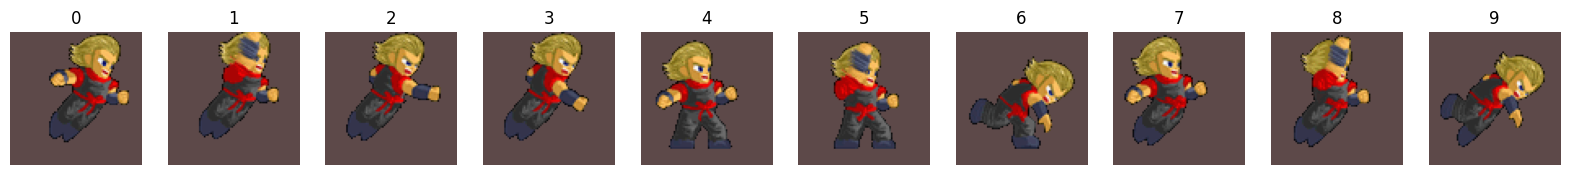

Enter motion name for frames in row 9 (or 'skip' to skip this row, or 'done' if finished with this row):  jump throw
Enter start index:  0
Enter end index:  


Invalid input. Please enter integers.


Enter motion name for frames in row 9 (or 'skip' to skip this row, or 'done' if finished with this row):  jump chop
Enter start index:  0
Enter end index:  3


Motion 'jump chop' frames saved in motion_frames/Firen/jump chop


Enter motion name for frames in row 9 (or 'skip' to skip this row, or 'done' if finished with this row):  run throw
Enter start index:  4
Enter end index:  6


Motion 'run throw' frames saved in motion_frames/Firen/run throw


Enter motion name for frames in row 9 (or 'skip' to skip this row, or 'done' if finished with this row):  jump throw
Enter start index:  7
Enter end index:  9


Motion 'jump throw' frames saved in motion_frames/Firen/jump throw


Enter motion name for frames in row 9 (or 'skip' to skip this row, or 'done' if finished with this row):  done


Finished defining motions for row 9.
Cache for row 9 cleared.


In [63]:
def process_character_sheet(image_path, character_name):
    character_dir = os.path.join(motion_frames_dir, character_name)
    cache_dir = os.path.join(character_dir, 'cache')
    frames = None
    rows = None

    if not os.path.exists(character_dir):
        os.mkdir(character_dir)
    # Check if the character has already been processed completely
    elif os.path.exists(os.path.join(character_dir, 'main.png')) and not os.path.exists(cache_dir):
        print(f"{character_name} has already been fully processed. Skipping.")
        return

    # Check if cache exists
    if not os.path.exists(cache_dir):
        # Open the image
        image = Image.open(image_path)
        print(f"Processing {character_name}...")

        # Step 2: Define motion part for segmentation
        x, y, w, h = define_motion_part(image)

        # Crop the image to motion part
        motion_part = image.crop((x, y, x + w, y + h))

        # Step 3: Define frame width and height and segment frames
        frames, cols, rows = segment_frames(motion_part)

        # Step 3: Save the first frame as main.png
        main_frame_path = save_main_image(frames, character_dir)
    
    # Step 4: Define motions and save frames with caching
    define_and_save_motions(character_dir,frames,rows)

    # Step 6: Generate character description using GPT
    # if not os.path.exists(os.path.join(character_dir, 'prompt.txt')):
    #     generate_character_description(main_frame_path, character_dir)
        
# Set up directories
spritesheet_dir = 'spritesheet'
motion_frames_dir = 'motion_frames'

# Ensure motion_frames directory exists
if not os.path.exists(motion_frames_dir):
    os.makedirs(motion_frames_dir)

# Iterate over the character sheet images
for filename in os.listdir(spritesheet_dir):
    if filename.endswith(('.png', '.jpg', '.jpeg')):
        character_name = os.path.splitext(filename)[0]
        image_path = os.path.join(spritesheet_dir, filename)
        process_character_sheet(image_path, character_name)